In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *
from train_test import *

from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import xgboost as xgb

sns.set_style('ticks')

testing `train-test.py`.

In [2]:
features_file_1 = 'featureSelection/selection_cleanMordredDescriptors.csv'
features_file_2 =  'deepnose_features.npy'

# Mordred features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

In [3]:
scaler = StandardScaler(with_mean=True, with_std=True)

# standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)

scaler = StandardScaler(with_mean=True, with_std=True)
# log standardize deepnose
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [4]:
CID2features_1 =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}
CID2features_2=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}

In [5]:
features_list = [CID2features_1, CID2features_2]
X_features, y_true = stacking_X_features(features_list, 'avg')

In [6]:
rf_best = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
xgb_best = {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.5}

In [7]:
rf_models = ensemble_models(X_features, y_true, rf_best, type = 'rf', num_models = 10)
xgb_models = ensemble_models(X_features, y_true, xgb_best, type = 'xgb', num_models = 10)

# models = ensemble_models_with_bootstrap(X_features, y_true, rf_best, type = 'rf', num_models = 10)

In [8]:
rf_y_preds = []
for model in rf_models:
    rf_y_pred = model.predict(X_features)
    rf_y_preds.append(rf_y_pred)
rf_y_pred_avg = np.array(rf_y_preds).mean(axis = 0)

In [9]:
xgb_y_preds = []
for model in xgb_models:
    xgb_y_pred = model.predict(X_features)
    xgb_y_preds.append(xgb_y_pred)
xgb_y_pred_avg = np.array(xgb_y_preds).mean(axis = 0)

In [10]:
corr = np.corrcoef(rf_y_pred_avg, y_true)[0, 1]
rmse = np.sqrt(mean_squared_error(y_true, rf_y_pred_avg))
print(f"Random Forest - training set R: {corr:.3f}")
print(f"Random Forest - training set RMSE: {rmse:.3f}")
print()

Random Forest - training set R: 0.983
Random Forest - training set RMSE: 0.044



In [11]:
corr = np.corrcoef(xgb_y_pred_avg, y_true)[0, 1]
rmse = np.sqrt(mean_squared_error(y_true, xgb_y_pred_avg))
print(f"XGBoost - training set R: {corr:.3f}")
print(f"XGBoost - training set RMSE: {rmse:.3f}")
print()

XGBoost - training set R: 0.996
XGBoost - training set RMSE: 0.021



In [12]:
X_test, y_test_true = stacking_X_test_features(features_list,  X_features, "avg")

In [13]:
rf_y_test_pred_avg = pred_mean(rf_models, X_test)
xgb_y_test_pred_avg = pred_mean(xgb_models, X_test)

In [14]:
rf_corr = np.corrcoef(rf_y_test_pred_avg, y_test_true)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_test_true), rf_y_test_pred_avg))

print(f"Random Forest - leaderboard R: {rf_corr:.3f}")
print(f"Random Forest - leaderboard RMSE: {rf_rmse:.3f}")


Random Forest - leaderboard R: 0.724
Random Forest - leaderboard RMSE: 0.120


In [15]:
xgb_corr = np.corrcoef(xgb_y_test_pred_avg, y_test_true)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_test_true), xgb_y_test_pred_avg))

print(f"XGBoost - leaderboard R: {xgb_corr:.3f}")
print(f"XGBoost - leaderboard RMSE: {xgb_rmse:.3f}")


XGBoost - leaderboard R: 0.716
XGBoost - leaderboard RMSE: 0.117


In [16]:
def combine_predictions(xgb_pred, rf_pred, threshold_low = 0.40566357, threshold_high = 0.61836108):
    combined = np.where(xgb_pred <= threshold_low, xgb_pred,
                        np.where(xgb_pred >= threshold_high, xgb_pred,
                                 rf_pred))
    return combined

combined_test_pred = combine_predictions(xgb_y_test_pred_avg, rf_y_test_pred_avg)
combined_pred = combine_predictions(xgb_y_pred_avg, rf_y_pred_avg)

combined_corr = np.corrcoef(combined_test_pred, y_test_true)[0, 1]
combined_rmse = np.sqrt(mean_squared_error(np.array(y_test_true), combined_test_pred))

print(f"Combined - R: {combined_corr:.3f}")
print(f"Combined - RMSE: {combined_rmse:.3f}")

Combined - R: 0.720
Combined - RMSE: 0.117


In [17]:
print(f"Random Forest - leaderboard R: {rf_corr:.3f}")
print(f"Random Forest - leaderboard RMSE: {rf_rmse:.3f}")
print()
print(f"XGBoost - leaderboard R: {xgb_corr:.3f}")
print(f"XGBoost - leaderboard RMSE: {xgb_rmse:.3f}")
print()
print(f"Combined - leaderboard R: {combined_corr:.3f}")
print(f"Combined - leaderboard RMSE: {combined_rmse:.3f}")

Random Forest - leaderboard R: 0.724
Random Forest - leaderboard RMSE: 0.120

XGBoost - leaderboard R: 0.716
XGBoost - leaderboard RMSE: 0.117

Combined - leaderboard R: 0.720
Combined - leaderboard RMSE: 0.117


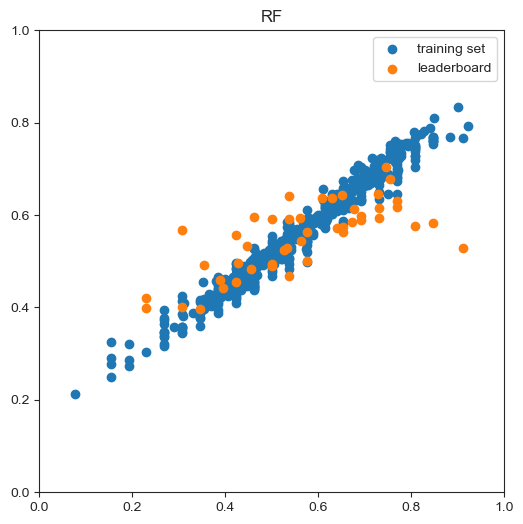

In [18]:
plt.figure(figsize = [6,6])
plt.scatter(y_true, rf_y_pred_avg, label = 'training set')
plt.scatter(y_test_true, rf_y_test_pred_avg, label = 'leaderboard')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('RF')
plt.show()

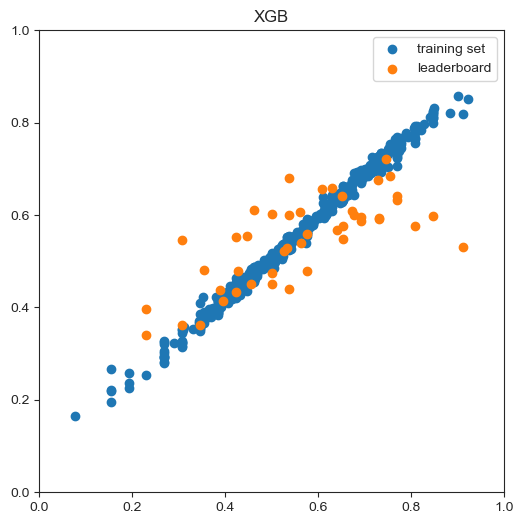

In [19]:
plt.figure(figsize = [6,6])
plt.scatter(y_true, xgb_y_pred_avg, label = 'training set')
plt.scatter(y_test_true, xgb_y_test_pred_avg, label = 'leaderboard')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('XGB')
plt.show()

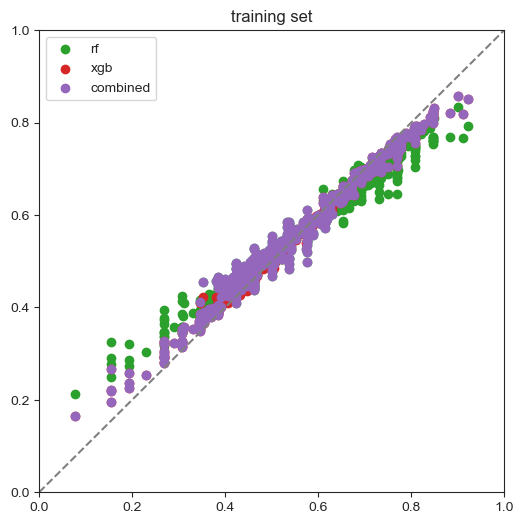

In [20]:
plt.figure(figsize = [6,6])
plt.scatter(y_true, rf_y_pred_avg, label = 'rf', color = 'C2')
plt.scatter(y_true, xgb_y_pred_avg, label = 'xgb', color = 'C3')
plt.scatter(y_true, combined_pred, label = 'combined', color = 'C4')
plt.plot([0, 1], [0, 1], ls = '--', c ='gray')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('training set')
plt.legend()
plt.show()


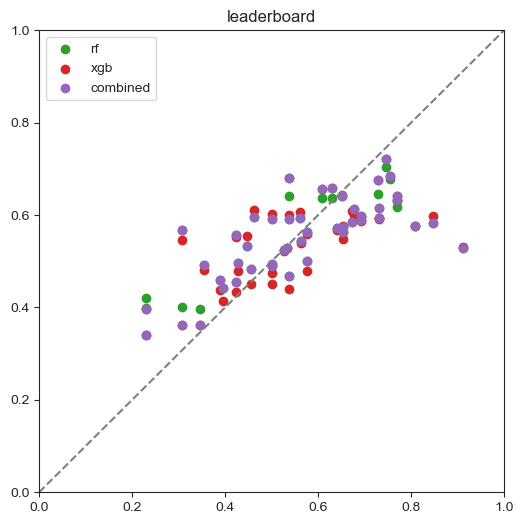

In [21]:
plt.figure(figsize = [6,6])
plt.scatter(y_test_true, rf_y_test_pred_avg, label = 'rf', color = 'C2')
plt.scatter(y_test_true, xgb_y_test_pred_avg, label = 'xgb', color = 'C3')
plt.scatter(y_test_true, combined_test_pred, label = 'combined', color = 'C4')
plt.plot([0, 1], [0, 1], ls = '--', c ='gray')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('leaderboard')
plt.legend()
plt.show()
